In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, recall_score
import lightgbm

# Импорт и предобработка данных

In [59]:
df_train = pd.read_csv('train_dataset_train.csv', index_col=0)
df_test = pd.read_csv('test_dataset_test.csv', index_col=0)

In [60]:
outliers = df_train[df_train.time_to_under >= df_train.time_to_under.quantile(0.99)].index
df_train = df_train.drop(outliers)
df_train.shape

(1080110, 11)

In [61]:
df_train, df_holdout = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train.label)

In [62]:
df_sub = pd.read_csv('subway.csv', index_col=0)
df_sub = df_sub[df_sub.optimal_route_delta == 0]
df_sub = df_sub.groupby('route_id').agg({'route_dur': min}).reset_index()
df_sub['station_id'] = df_sub.route_id.apply(lambda x: x.split('_')[0]).astype(int)
df_sub['label'] = df_sub.route_id.apply(lambda x: x.split('_')[1]).astype(int)
df_sub.drop('route_id', axis=1, inplace=True)

In [63]:
df_train = df_train.merge(df_sub, how='left', left_on=['station_id', 'label'], right_on=['station_id', 'label'])
df_train['workday_len'] = df_train.time_to_under - df_train.route_dur
df_train['workday_len'] = df_train.workday_len.where(df_train.workday_len>0, 0)
df_train['route_dur'] = df_train.time_to_under - df_train.workday_len

In [64]:
# СТАТИСТИКИ ВРЕМЕНИ ПО ТИПУ БИЛЕТОВ
time_by_ticket_type_stats = df_train.groupby('ticket_type_nm')\
                               .agg({'time_to_under': [('time_min', min), ('time_max', max), ('time_mean', np.mean), ('time_median', np.median), ('time_std', np.std)],
                                     'workday_len': [('workday_min', min), ('workday_max', max), ('workday_mean', np.mean), ('workday_median', np.median), ('workday_std', np.std)],
                                     'route_dur': [('route_min', min), ('route_max', max), ('route_mean', np.mean), ('route_median', np.median), ('route_std', np.std)]})\
                               .droplevel(0, axis=1)

In [65]:
def process_date(df):
    df.pass_dttm = pd.to_datetime(df.pass_dttm)
    df['time_of_day'] = pd.cut(df.pass_dttm.dt.hour, [i for i in range(0, 25)], labels=range(24), right=False)
    df['is_dayoff'] = df.pass_dttm.dt.weekday.isin([5,6]).astype(int)
    df['weekday'] = df.pass_dttm.dt.weekday
    df['time_to_close'] = (25 * 60) - ((df.pass_dttm.dt.hour * 60) + df.pass_dttm.dt.minute)
    df['time_from_open'] = ((df.pass_dttm.dt.hour * 60) + df.pass_dttm.dt.minute) - (5.5 * 60)   

In [66]:
def process_ticket_types(df, ticket_category):
    student = df[df.ticket_type_nm.str.contains('студен') | df.ticket_type_nm.str.contains('учащ') | 
                       df.ticket_type_nm.str.contains('ордин') | df.ticket_type_nm.str.contains('аспир')].ticket_type_nm.unique()
    df['is_student'] = (df.ticket_type_nm.isin(student)).astype(int)
    suburb = df[df.ticket_type_nm.str.contains('Пригор') | df.ticket_type_nm.str.contains('област')].ticket_type_nm.unique()
    df['is_suburb'] = (df.ticket_type_nm.isin(suburb)).astype(int)
    df['ticket_type_cat'] = df.ticket_type_nm.map(ticket_category)

In [67]:
df_train = df_train.merge(time_by_ticket_type_stats, how='left', left_on='ticket_type_nm', right_index=True)
df_holdout = df_holdout.merge(time_by_ticket_type_stats, how='left', left_on='ticket_type_nm', right_index=True)
df_test = df_test.merge(time_by_ticket_type_stats, how='left', left_on='ticket_type_nm', right_index=True)

df_train = df_train.merge(df_sub[df_sub.label == 1009][['route_dur', 'station_id']], how='left', left_on='station_id', right_on='station_id', suffixes=(None, '_to_center'))
df_holdout = df_holdout.merge(df_sub[df_sub.label == 1009][['route_dur', 'station_id']], how='left', left_on='station_id', right_on='station_id', suffixes=(None, '_to_center'))
df_test = df_test.merge(df_sub[df_sub.label == 1009][['route_dur', 'station_id']], how='left', left_on='station_id', right_on='station_id', suffixes=(None, '_to_center'))

In [68]:
ticket_category = {k:v for v, k in enumerate(df_train.ticket_type_nm.unique())}

for df in [df_train, df_test, df_holdout]:
    process_date(df)
    process_ticket_types(df, ticket_category)

# Train/test split

In [69]:
X = df_train.drop(['ticket_id', 'entrance_nm', 'station_nm', 'line_nm', 'pass_dttm', 'time_to_under', 'label', 'ticket_type_nm', 'workday_len', 'route_dur'], axis=1)
y = df_train[['time_to_under', 'label']]
X_test = df_holdout.drop(['ticket_id', 'entrance_nm', 'station_nm', 'line_nm', 'pass_dttm', 'ticket_type_nm','time_to_under', 'label'], axis=1)
y_test = df_holdout[['time_to_under', 'label']]
df_test_final = df_test.drop(['ticket_id', 'entrance_nm', 'station_nm', 'line_nm', 'pass_dttm', 'ticket_type_nm'], axis=1)

In [70]:
cat_features = ['entrance_id', 'station_id', 'line_id', 'time_of_day', 'is_dayoff', 'weekday', 'is_student', 'is_suburb', 'ticket_type_cat']
X[cat_features] = X[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')
df_test_final[cat_features] = df_test_final[cat_features].astype('category')

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972099 entries, 0 to 972098
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   entrance_id          972099 non-null  category
 1   station_id           972099 non-null  category
 2   line_id              972099 non-null  category
 3   time_of_day          972099 non-null  category
 4   is_dayoff            972099 non-null  category
 5   weekday              972099 non-null  category
 6   time_to_close        972099 non-null  int64   
 7   time_from_open       972099 non-null  float64 
 8   is_student           972099 non-null  category
 9   is_suburb            972099 non-null  category
 10  ticket_type_cat      972099 non-null  category
 11  time_min             972099 non-null  float64 
 12  time_max             972099 non-null  float64 
 13  time_mean            972099 non-null  float64 
 14  time_median          972099 non-null  float64 
 15  

In [71]:
print(X_train.shape, X_valid.shape, X_test.shape)

(785535, 27) (196383, 27) (108011, 27)


# Regression

In [75]:
import optuna
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

def objective(trial, X, y):
    #models = []
    kf = KFold(random_state=42, shuffle=True)
    CV_res=[]
    for i, (trn_idx, tst_idx) in enumerate(kf.split(X)):
        X_train, X_valid, y_train, y_valid = X.iloc[trn_idx], X.iloc[tst_idx], y.time_to_under.iloc[trn_idx], y.time_to_under.iloc[tst_idx]
        
        param_grid = {
            "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
            "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 3020, step=20),
            "max_depth": trial.suggest_int("max_depth", 0, 12),
            #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 3000, step=50),
            "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=2),
            "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=2),
            #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.05),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 150),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.75, 1, step=0.05),
            "verbosity" : trial.suggest_categorical("verbosity", [-1])
        }

        lgtrain, lgval = lightgbm.Dataset(X_train, y_train), lightgbm.Dataset(X_valid, y_valid)
        lgbmodel = lightgbm.train(param_grid, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(200), lightgbm.early_stopping(50)])
        
        r2 = r2_score(y_test.time_to_under, lgbmodel.predict(X_test))
        print(r2)
        CV_res.append(r2)
        #models.append(lgbmodel)
    return np.mean(CV_res)

study = optuna.create_study(direction="maximize", study_name="LGBM Regressor", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=50)

[I 2022-11-25 09:29:55,635] A new study created in memory with name: LGBM Regressor


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 21316.1	valid_1's l2: 24455.4
0.531382488147181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 21472.5	valid_1's l2: 24469.6
0.5320585274323906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 21540.7	valid_1's l2: 24233.8
0.5326836943463218
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's l2: 21313.7	valid_1's l2: 24541.9
0.5323917914169716
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	training's l2: 21505.7	valid_1's l2: 24161.3


[I 2022-11-25 09:30:59,332] Trial 0 finished with value: 0.5321894181608379 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2105458678851937, 'num_leaves': 2000, 'max_depth': 0, 'lambda_l1': 34, 'lambda_l2': 0, 'bagging_fraction': 0.75, 'bagging_freq': 137, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 0 with value: 0.5321894181608379.


0.5324305894613244
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24023.1	valid_1's l2: 24268.5
[400]	training's l2: 23857.6	valid_1's l2: 24188.3
[600]	training's l2: 23739.4	valid_1's l2: 24143.1
[800]	training's l2: 23635.8	valid_1's l2: 24109.8
[1000]	training's l2: 23566.3	valid_1's l2: 24093.9
[1200]	training's l2: 23498.2	valid_1's l2: 24081.8
Early stopping, best iteration is:
[1253]	training's l2: 23484.6	valid_1's l2: 24080.8
0.5397136893287374
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24026	valid_1's l2: 24285.1
[400]	training's l2: 23860.2	valid_1's l2: 24194.6
[600]	training's l2: 23739.4	valid_1's l2: 24155.4
[800]	training's l2: 23647.9	valid_1's l2: 24127.6
[1000]	training's l2: 23573.1	valid_1's l2: 24107
[1200]	training's l2: 23511.1	valid_1's l2: 24099.9
Early stopping, best iteration is:
[1173]	training's l2: 23516.9	valid_1's l2: 24099
0.5394648069700354
Training until validation scores don'

[I 2022-11-25 09:34:15,529] Trial 1 finished with value: 0.5395598727221469 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09103565431295048, 'num_leaves': 2900, 'max_depth': 3, 'lambda_l1': 96, 'lambda_l2': 8, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 116, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 1 with value: 0.5395598727221469.


0.5396268364890913
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24180	valid_1's l2: 24398.7
[400]	training's l2: 24022.6	valid_1's l2: 24320.7
[600]	training's l2: 23922.9	valid_1's l2: 24270.7
Early stopping, best iteration is:
[749]	training's l2: 23864.8	valid_1's l2: 24250
0.536495380327076
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24148.3	valid_1's l2: 24384.5
[400]	training's l2: 24014	valid_1's l2: 24322.2
[600]	training's l2: 23905.3	valid_1's l2: 24283.1
Early stopping, best iteration is:
[724]	training's l2: 23851.1	valid_1's l2: 24263.2
0.536022549156024
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24248.3	valid_1's l2: 24188.3
[400]	training's l2: 24094.7	valid_1's l2: 24112.2
[600]	training's l2: 23985.3	valid_1's l2: 24059.7
Early stopping, best iteration is:
[666]	training's l2: 23960.4	valid_1's l2: 24042.3
0.5353474148404317
Training until validation scores

[I 2022-11-25 09:35:25,770] Trial 2 finished with value: 0.5357499537609463 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2715870011944763, 'num_leaves': 2440, 'max_depth': 2, 'lambda_l1': 72, 'lambda_l2': 68, 'bagging_fraction': 0.55, 'bagging_freq': 60, 'feature_fraction': 0.95, 'verbosity': -1}. Best is trial 1 with value: 0.5395598727221469.


0.5355595456843666
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23362.6	valid_1's l2: 24080.7
Early stopping, best iteration is:
[289]	training's l2: 23184.4	valid_1's l2: 24072.3
0.5393130032446642
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23369.8	valid_1's l2: 24106.6
Early stopping, best iteration is:
[224]	training's l2: 23305.1	valid_1's l2: 24095.7
0.5386207766501931
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23443	valid_1's l2: 23855
Early stopping, best iteration is:
[271]	training's l2: 23292.8	valid_1's l2: 23839.4
0.5392432662708135
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23362.2	valid_1's l2: 24176.5
Early stopping, best iteration is:
[256]	training's l2: 23241.5	valid_1's l2: 24167.5
0.5392776051579693
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23449.6	valid_1's l2: 23809.7
[400]

[I 2022-11-25 09:36:31,481] Trial 3 finished with value: 0.5391456782655071 and parameters: {'n_estimators': 10000, 'learning_rate': 0.275921867820335, 'num_leaves': 2660, 'max_depth': 4, 'lambda_l1': 38, 'lambda_l2': 0, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 56, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 1 with value: 0.5395598727221469.


0.5392737400038949
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 21136.2	valid_1's l2: 24086.2
0.5383106841852008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 21067.8	valid_1's l2: 24121.5
0.5384648278073685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 21141.3	valid_1's l2: 23874.9
0.5387716972896608
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 21112.7	valid_1's l2: 24204.7
0.5384054485143732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 21177.9	valid_1's l2: 23839


[I 2022-11-25 09:38:22,045] Trial 4 finished with value: 0.5385884853459205 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11060008785547483, 'num_leaves': 1960, 'max_depth': 0, 'lambda_l1': 50, 'lambda_l2': 26, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 8, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 1 with value: 0.5395598727221469.


0.5389897689329994
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	training's l2: 21528.8	valid_1's l2: 24130.1
0.5375264165825244
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's l2: 22073.4	valid_1's l2: 24171.6
0.53751907807537
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's l2: 22144.1	valid_1's l2: 23973.9
0.5375879197569546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 21672.5	valid_1's l2: 24237.4
0.537068936941379
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's l2: 22202.3	valid_1's l2: 23880.8


[I 2022-11-25 09:39:14,043] Trial 5 finished with value: 0.537474598209258 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24014118140192192, 'num_leaves': 1540, 'max_depth': 11, 'lambda_l1': 86, 'lambda_l2': 8, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 34, 'feature_fraction': 0.9, 'verbosity': -1}. Best is trial 1 with value: 0.5395598727221469.


0.5376706396900621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	training's l2: 22527.4	valid_1's l2: 24268.7
0.5354812885902165
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	training's l2: 22972.7	valid_1's l2: 24302.2
0.53432840811318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	training's l2: 22616.7	valid_1's l2: 24096.7
0.5354135326727181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	training's l2: 22518.4	valid_1's l2: 24418.3
0.5353510066386258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	training's l2: 22850.4	valid_1's l2: 23987.7


[I 2022-11-25 09:40:28,847] Trial 6 finished with value: 0.5351375680832853 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07354769846609892, 'num_leaves': 1280, 'max_depth': 11, 'lambda_l1': 10, 'lambda_l2': 22, 'bagging_fraction': 0.35000000000000003, 'bagging_freq': 31, 'feature_fraction': 0.95, 'verbosity': -1}. Best is trial 1 with value: 0.5395598727221469.


0.535113604401686
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23493.7	valid_1's l2: 24070.6
[400]	training's l2: 23189.5	valid_1's l2: 24034.9
Early stopping, best iteration is:
[394]	training's l2: 23199.1	valid_1's l2: 24032.9
0.5403408638915679
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23507.3	valid_1's l2: 24081.9
[400]	training's l2: 23223.3	valid_1's l2: 24053
Early stopping, best iteration is:
[504]	training's l2: 23109.2	valid_1's l2: 24046.9
0.5402430675617147
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23546.6	valid_1's l2: 23856.3
[400]	training's l2: 23258	valid_1's l2: 23820
Early stopping, best iteration is:
[445]	training's l2: 23200.4	valid_1's l2: 23813.3
0.5401109142646069
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23479.9	valid_1's l2: 24186.9
[400]	training's l2: 23177.3	valid_1's l2: 24140.1
Early stopping, best 

[I 2022-11-25 09:42:02,181] Trial 7 finished with value: 0.5401218277851854 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17992147980232254, 'num_leaves': 2900, 'max_depth': 4, 'lambda_l1': 82, 'lambda_l2': 12, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 109, 'feature_fraction': 0.9, 'verbosity': -1}. Best is trial 7 with value: 0.5401218277851854.


0.540177393014256
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24362.9	valid_1's l2: 24530.9
[400]	training's l2: 24316.7	valid_1's l2: 24508.6
[600]	training's l2: 24275.2	valid_1's l2: 24492.7
[800]	training's l2: 24227.6	valid_1's l2: 24465.7
[1000]	training's l2: 24169.3	valid_1's l2: 24430.4
[1200]	training's l2: 24134.7	valid_1's l2: 24417.2
Early stopping, best iteration is:
[1180]	training's l2: 24136.5	valid_1's l2: 24411.9
0.5332511317677563
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24369.3	valid_1's l2: 24563.7
[400]	training's l2: 24321.2	valid_1's l2: 24539.4
[600]	training's l2: 24274.5	valid_1's l2: 24517.2
[800]	training's l2: 24226.9	valid_1's l2: 24490.1
[1000]	training's l2: 24187.6	valid_1's l2: 24476.7
Early stopping, best iteration is:
[970]	training's l2: 24192.4	valid_1's l2: 24475
0.5325053686730132
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24437

[I 2022-11-25 09:43:49,866] Trial 8 finished with value: 0.5325927259387326 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1979612119813226, 'num_leaves': 2580, 'max_depth': 2, 'lambda_l1': 24, 'lambda_l2': 48, 'bagging_fraction': 0.45, 'bagging_freq': 3, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 7 with value: 0.5401218277851854.


0.5328854980295517
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24964	valid_1's l2: 25088.4
Early stopping, best iteration is:
[345]	training's l2: 24955.1	valid_1's l2: 25080.3
0.5203506463980798
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24960.2	valid_1's l2: 25117.7
Early stopping, best iteration is:
[293]	training's l2: 24952.9	valid_1's l2: 25109
0.5202626558087888
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 25021.3	valid_1's l2: 24888.4
Early stopping, best iteration is:
[349]	training's l2: 25008.3	valid_1's l2: 24878.2
0.5203850928037846
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24925.3	valid_1's l2: 25218
Early stopping, best iteration is:
[290]	training's l2: 24918.3	valid_1's l2: 25210.9
0.5202095705550898
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 25042.5	valid_1's l2: 24771.4
Early s

[I 2022-11-25 09:44:23,176] Trial 9 finished with value: 0.5202724053434241 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19084664679362462, 'num_leaves': 580, 'max_depth': 1, 'lambda_l1': 98, 'lambda_l2': 90, 'bagging_fraction': 0.65, 'bagging_freq': 29, 'feature_fraction': 1.0, 'verbosity': -1}. Best is trial 7 with value: 0.5401218277851854.


0.5201540611513776
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's l2: 24004.6	valid_1's l2: 24476
0.5318344694464734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's l2: 24008.4	valid_1's l2: 24488.4
0.5312488221019467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 24061.7	valid_1's l2: 24299
0.5311955469945515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's l2: 23963.3	valid_1's l2: 24587
0.5314158487818003
Training until validation scores don't improve for 50 rounds


[I 2022-11-25 09:44:42,795] Trial 10 finished with value: 0.5315302100345077 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1397471082881877, 'num_leaves': 60, 'max_depth': 7, 'lambda_l1': 70, 'lambda_l2': 46, 'bagging_fraction': 0.2, 'bagging_freq': 96, 'feature_fraction': 0.9, 'verbosity': -1}. Best is trial 7 with value: 0.5401218277851854.


Early stopping, best iteration is:
[30]	training's l2: 24061.5	valid_1's l2: 24143.9
0.5319563628477666
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23322.9	valid_1's l2: 24038.6
[400]	training's l2: 23037.6	valid_1's l2: 23972.5
[600]	training's l2: 22812.9	valid_1's l2: 23946.1
Early stopping, best iteration is:
[655]	training's l2: 22758.7	valid_1's l2: 23941
0.5419356933894989
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23339.3	valid_1's l2: 24050.5
[400]	training's l2: 23066.7	valid_1's l2: 23989
[600]	training's l2: 22823.1	valid_1's l2: 23954.5
Early stopping, best iteration is:
[694]	training's l2: 22735.9	valid_1's l2: 23947.1
0.5420233892367072
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23381.1	valid_1's l2: 23830.8
[400]	training's l2: 23094.6	valid_1's l2: 23770
[600]	training's l2: 22850.8	valid_1's l2: 23736.9
[800]	training's l2: 22671.5	valid_1's l2: 23725.6

[I 2022-11-25 09:48:31,047] Trial 11 finished with value: 0.5419166533741924 and parameters: {'n_estimators': 10000, 'learning_rate': 0.051471445281696226, 'num_leaves': 2920, 'max_depth': 6, 'lambda_l1': 100, 'lambda_l2': 26, 'bagging_fraction': 0.95, 'bagging_freq': 115, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5421442858746027
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22364.2	valid_1's l2: 23969.2
Early stopping, best iteration is:
[216]	training's l2: 22289.2	valid_1's l2: 23965
0.5410841711952309
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22448.4	valid_1's l2: 23983.3
Early stopping, best iteration is:
[226]	training's l2: 22349	valid_1's l2: 23979.3
0.5410864002638862
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22476.9	valid_1's l2: 23764.6
Early stopping, best iteration is:
[224]	training's l2: 22376.5	valid_1's l2: 23761.2
0.5414940434660931
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22405.9	valid_1's l2: 24050.5
Early stopping, best iteration is:
[245]	training's l2: 22234.4	valid_1's l2: 24045.6
0.5409350843841817
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22475.2	valid_1's l2: 23694.4
Early

[I 2022-11-25 09:50:02,929] Trial 12 finished with value: 0.5412449502468215 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14102964504319349, 'num_leaves': 3020, 'max_depth': 7, 'lambda_l1': 74, 'lambda_l2': 30, 'bagging_fraction': 0.95, 'bagging_freq': 147, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5416250519247157
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23140.3	valid_1's l2: 24060
[400]	training's l2: 22813.6	valid_1's l2: 24004.7
Early stopping, best iteration is:
[501]	training's l2: 22683.7	valid_1's l2: 23990.5
0.540483306886905
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23126.7	valid_1's l2: 24082.1
[400]	training's l2: 22824.5	valid_1's l2: 24025.4
Early stopping, best iteration is:
[516]	training's l2: 22675.6	valid_1's l2: 24012.8
0.5406503260252364
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23176.5	valid_1's l2: 23866.2
[400]	training's l2: 22883.7	valid_1's l2: 23808.8
[600]	training's l2: 22608	valid_1's l2: 23784.5
Early stopping, best iteration is:
[614]	training's l2: 22593.8	valid_1's l2: 23782.6
0.5407872895093286
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23106.1	valid_1's l2: 24160.3
[400]	training's l2

[I 2022-11-25 09:53:07,087] Trial 13 finished with value: 0.5407312368195074 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05151841477961682, 'num_leaves': 2140, 'max_depth': 7, 'lambda_l1': 60, 'lambda_l2': 36, 'bagging_fraction': 0.7, 'bagging_freq': 145, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5413042208734244
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	training's l2: 21984.3	valid_1's l2: 23963.5
0.540828758672288
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21650.1	valid_1's l2: 23991.5
Early stopping, best iteration is:
[167]	training's l2: 21842.4	valid_1's l2: 23978.2
0.5409425579753839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	training's l2: 22095.5	valid_1's l2: 23758.1
0.5414256191122329
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21623.5	valid_1's l2: 24075.1
Early stopping, best iteration is:
[151]	training's l2: 21930.6	valid_1's l2: 24065.6
0.5406993654300443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	training's l2: 21981.7	valid_1's l2: 23705.4


[I 2022-11-25 09:54:34,733] Trial 14 finished with value: 0.541047474749976 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14365792083272694, 'num_leaves': 3020, 'max_depth': 9, 'lambda_l1': 80, 'lambda_l2': 62, 'bagging_fraction': 0.95, 'bagging_freq': 125, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5413410725599317
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	training's l2: 22051.3	valid_1's l2: 24039
0.5388933516691057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	training's l2: 22009.8	valid_1's l2: 24072.4
0.5398023320566758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	training's l2: 22207.7	valid_1's l2: 23853
0.5393752456450416
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	training's l2: 22034.9	valid_1's l2: 24138.8
0.5394781892273466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	training's l2: 22255.5	valid_1's l2: 23791.2


[I 2022-11-25 09:55:53,216] Trial 15 finished with value: 0.5395119567307125 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1359242798299862, 'num_leaves': 1440, 'max_depth': 9, 'lambda_l1': 98, 'lambda_l2': 32, 'bagging_fraction': 0.75, 'bagging_freq': 87, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5400106650553924
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23485.8	valid_1's l2: 24109.5
[400]	training's l2: 23271.2	valid_1's l2: 24058.5
[600]	training's l2: 23107.8	valid_1's l2: 24032.8
[800]	training's l2: 22952.7	valid_1's l2: 24018.7
Early stopping, best iteration is:
[789]	training's l2: 22960.1	valid_1's l2: 24018.1
0.5404988540578356
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23476.4	valid_1's l2: 24121.9
[400]	training's l2: 23286.6	valid_1's l2: 24072.2
[600]	training's l2: 23089.7	valid_1's l2: 24039.8
Early stopping, best iteration is:
[602]	training's l2: 23088.5	valid_1's l2: 24039.1
0.5403036781895789
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23544.2	valid_1's l2: 23909.4
[400]	training's l2: 23342.8	valid_1's l2: 23856.7
Early stopping, best iteration is:
[501]	training's l2: 23240.2	valid_1's l2: 23844
0.5395836758468461
Training until validation 

[I 2022-11-25 09:58:35,411] Trial 16 finished with value: 0.5401979404705903 and parameters: {'n_estimators': 10000, 'learning_rate': 0.050080280903395336, 'num_leaves': 2380, 'max_depth': 6, 'lambda_l1': 58, 'lambda_l2': 60, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 146, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5404179331775272
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23075.2	valid_1's l2: 24018.1
[400]	training's l2: 22659	valid_1's l2: 23987
Early stopping, best iteration is:
[396]	training's l2: 22664.3	valid_1's l2: 23986.1
0.5409107306424146
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23098.9	valid_1's l2: 24022.6
[400]	training's l2: 22690.2	valid_1's l2: 23998.8
Early stopping, best iteration is:
[429]	training's l2: 22634.3	valid_1's l2: 23997.9
0.540888291698798
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23138.1	valid_1's l2: 23808.5
Early stopping, best iteration is:
[287]	training's l2: 22944.4	valid_1's l2: 23789.6
0.5404912934320338
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23063.8	valid_1's l2: 24122.9
[400]	training's l2: 22680.9	valid_1's l2: 24095.2
Early stopping, best iteration is:
[360]	training's l2: 22741	valid_1'

[I 2022-11-25 10:00:23,793] Trial 17 finished with value: 0.5406799703242996 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10899155970249066, 'num_leaves': 760, 'max_depth': 6, 'lambda_l1': 68, 'lambda_l2': 40, 'bagging_fraction': 0.8, 'bagging_freq': 129, 'feature_fraction': 0.95, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5408913957546813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	training's l2: 22136	valid_1's l2: 24038
0.5395706393334306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	training's l2: 21878.4	valid_1's l2: 24063.2
0.5395206217657794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's l2: 22237.9	valid_1's l2: 23837.6
0.5399298737712224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	training's l2: 21798.6	valid_1's l2: 24146.3
0.539128855032839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	training's l2: 22274.4	valid_1's l2: 23766.5


[I 2022-11-25 10:01:17,284] Trial 18 finished with value: 0.5396703113972171 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2377532391553559, 'num_leaves': 1720, 'max_depth': 9, 'lambda_l1': 88, 'lambda_l2': 20, 'bagging_fraction': 0.95, 'bagging_freq': 107, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.540201567082814
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23431.6	valid_1's l2: 24154.3
Early stopping, best iteration is:
[239]	training's l2: 23355.9	valid_1's l2: 24146.1
0.5386297584250529
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23431.6	valid_1's l2: 24156.3
Early stopping, best iteration is:
[164]	training's l2: 23503.7	valid_1's l2: 24154.7
0.5377939509690874
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23506.6	valid_1's l2: 23918
Early stopping, best iteration is:
[235]	training's l2: 23435.5	valid_1's l2: 23910.9
0.5382809925011853
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23432.1	valid_1's l2: 24234.6
[400]	training's l2: 23111.5	valid_1's l2: 24212.5
Early stopping, best iteration is:
[392]	training's l2: 23119.7	valid_1's l2: 24210
0.5379675843749927
Training until validation scores don't improve for 50 rounds
[200]	

[I 2022-11-25 10:02:13,029] Trial 19 finished with value: 0.5381786956133447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1641154324688307, 'num_leaves': 1080, 'max_depth': 5, 'lambda_l1': 76, 'lambda_l2': 78, 'bagging_fraction': 0.5, 'bagging_freq': 77, 'feature_fraction': 0.9, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5382211917964053
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23228.3	valid_1's l2: 24244.3
Early stopping, best iteration is:
[202]	training's l2: 23225.2	valid_1's l2: 24244.2
0.5361607824560259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	training's l2: 23577.4	valid_1's l2: 24332.5
0.5342178987700306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	training's l2: 23630.9	valid_1's l2: 24114.3
0.5346668211867542
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23191.6	valid_1's l2: 24349.7
Early stopping, best iteration is:
[203]	training's l2: 23185.3	valid_1's l2: 24349
0.5355270852821553
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	training's l2: 23642	valid_1's l2: 23993.2


[I 2022-11-25 10:02:59,316] Trial 20 finished with value: 0.5352331214895072 and parameters: {'n_estimators': 10000, 'learning_rate': 0.085947771233737, 'num_leaves': 2220, 'max_depth': 8, 'lambda_l1': 90, 'lambda_l2': 100, 'bagging_fraction': 0.35000000000000003, 'bagging_freq': 123, 'feature_fraction': 1.0, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5355930197525697
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21549.7	valid_1's l2: 23965.1
Early stopping, best iteration is:
[161]	training's l2: 21776.7	valid_1's l2: 23954.6
0.5409081917965394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	training's l2: 21990.8	valid_1's l2: 24011.9
0.5410965481879759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	training's l2: 22192.6	valid_1's l2: 23776.7
0.5412498469495501
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	training's l2: 21939.8	valid_1's l2: 24061.2
0.54064150955096
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21643.4	valid_1's l2: 23737.1
Early stopping, best iteration is:
[150]	training's l2: 21928.6	valid_1's l2: 23718.6


[I 2022-11-25 10:04:22,796] Trial 21 finished with value: 0.5410497004430969 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14950684248467944, 'num_leaves': 3020, 'max_depth': 9, 'lambda_l1': 78, 'lambda_l2': 58, 'bagging_fraction': 0.95, 'bagging_freq': 129, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5413524057304586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	training's l2: 21512.5	valid_1's l2: 24031.5
0.539359216768164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	training's l2: 21347	valid_1's l2: 24062.5
0.5397958702578494
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	training's l2: 21167.5	valid_1's l2: 23844.1
0.5398741260668689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	training's l2: 21394.5	valid_1's l2: 24115.5
0.5396288517449097
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	training's l2: 21580.7	valid_1's l2: 23771.3


[I 2022-11-25 10:05:47,254] Trial 22 finished with value: 0.5397606449438817 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1597918693525809, 'num_leaves': 2740, 'max_depth': 12, 'lambda_l1': 62, 'lambda_l2': 56, 'bagging_fraction': 0.95, 'bagging_freq': 138, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5401451598816165
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22361.8	valid_1's l2: 23990.7
Early stopping, best iteration is:
[243]	training's l2: 22209.1	valid_1's l2: 23982.9
0.5402536514366687
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22401.4	valid_1's l2: 24029.2
Early stopping, best iteration is:
[207]	training's l2: 22380	valid_1's l2: 24028.6
0.5403077838616566
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22446.1	valid_1's l2: 23809.4
Early stopping, best iteration is:
[204]	training's l2: 22432.7	valid_1's l2: 23808.6
0.5402675477442057
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22326.9	valid_1's l2: 24098
Early stopping, best iteration is:
[215]	training's l2: 22273.2	valid_1's l2: 24094.7
0.5403965490626601
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22494.5	valid_1's l2: 23736.4
Early

[I 2022-11-25 10:07:23,974] Trial 23 finished with value: 0.5403808382858625 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11719224705463317, 'num_leaves': 3020, 'max_depth': 8, 'lambda_l1': 52, 'lambda_l2': 74, 'bagging_fraction': 0.8, 'bagging_freq': 99, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5406786593241214
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	training's l2: 21980.3	valid_1's l2: 24076.7
0.5381570053841864
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	training's l2: 22150.4	valid_1's l2: 24114.4
0.5390714526855098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	training's l2: 22419	valid_1's l2: 23890.7
0.5388853662023566
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	training's l2: 22047.1	valid_1's l2: 24167.2
0.5383344628619646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	training's l2: 22144.2	valid_1's l2: 23824.7


[I 2022-11-25 10:08:15,511] Trial 24 finished with value: 0.5386984765759368 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21705704960102779, 'num_leaves': 2740, 'max_depth': 10, 'lambda_l1': 100, 'lambda_l2': 30, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 150, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5390440957456666
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22863.5	valid_1's l2: 23978.9
[400]	training's l2: 22369.7	valid_1's l2: 23930.3
Early stopping, best iteration is:
[448]	training's l2: 22279.9	valid_1's l2: 23927.8
0.5420347956599689
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22830.5	valid_1's l2: 23994
[400]	training's l2: 22375.2	valid_1's l2: 23952.7
Early stopping, best iteration is:
[413]	training's l2: 22357.3	valid_1's l2: 23952.6
0.5419517718011795
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22894.6	valid_1's l2: 23767.3
[400]	training's l2: 22455.5	valid_1's l2: 23722.1
Early stopping, best iteration is:
[465]	training's l2: 22323.8	valid_1's l2: 23717.5
0.5418734656553296
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22823.7	valid_1's l2: 24074.9
[400]	training's l2: 22368.2	valid_1's l2: 24029.4
Early stopping, 

[I 2022-11-25 10:10:54,418] Trial 25 finished with value: 0.5418774090902776 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07484229146344334, 'num_leaves': 2440, 'max_depth': 7, 'lambda_l1': 90, 'lambda_l2': 42, 'bagging_fraction': 0.95, 'bagging_freq': 132, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5421476073558763
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23615.7	valid_1's l2: 24109.9
[400]	training's l2: 23361.3	valid_1's l2: 24050
[600]	training's l2: 23165	valid_1's l2: 24025.3
[800]	training's l2: 23001.3	valid_1's l2: 24013.2
Early stopping, best iteration is:
[816]	training's l2: 22991.7	valid_1's l2: 24011.3
0.5407673106922286
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23618.6	valid_1's l2: 24102.8
[400]	training's l2: 23370.7	valid_1's l2: 24049.5
[600]	training's l2: 23210.3	valid_1's l2: 24027.6
[800]	training's l2: 23048.9	valid_1's l2: 24015.3
[1000]	training's l2: 22922.2	valid_1's l2: 24004.5
Early stopping, best iteration is:
[1042]	training's l2: 22890.7	valid_1's l2: 24000.9
0.5404960554402074
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23644.1	valid_1's l2: 23895.6
[400]	training's l2: 23401	valid_1's l2: 23826.1
[600]	training's l2: 23208.8	va

[I 2022-11-25 10:13:43,239] Trial 26 finished with value: 0.5405589731328408 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07403336573886787, 'num_leaves': 2440, 'max_depth': 5, 'lambda_l1': 92, 'lambda_l2': 40, 'bagging_fraction': 0.75, 'bagging_freq': 115, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5409201696053803
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22938.7	valid_1's l2: 24018
[400]	training's l2: 22493.7	valid_1's l2: 23956.7
Early stopping, best iteration is:
[410]	training's l2: 22476.9	valid_1's l2: 23954.9
0.5413596324727505
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22929.1	valid_1's l2: 24032.1
[400]	training's l2: 22527.5	valid_1's l2: 23989.6
Early stopping, best iteration is:
[407]	training's l2: 22516.4	valid_1's l2: 23988.1
0.5414019369444751
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22971.6	valid_1's l2: 23813.3
[400]	training's l2: 22567.5	valid_1's l2: 23760.1
Early stopping, best iteration is:
[542]	training's l2: 22325.5	valid_1's l2: 23744.4
0.541257772458396
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22891.6	valid_1's l2: 24109.1
[400]	training's l2: 22443.3	valid_1's l2: 24045.8
Early stopping, b

[I 2022-11-25 10:16:01,642] Trial 27 finished with value: 0.5412460975028364 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06573790959732846, 'num_leaves': 2580, 'max_depth': 7, 'lambda_l1': 84, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 133, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5411665738279787
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23598	valid_1's l2: 24115.9
[400]	training's l2: 23388.4	valid_1's l2: 24058.4
[600]	training's l2: 23201.5	valid_1's l2: 24029.9
Early stopping, best iteration is:
[631]	training's l2: 23177.1	valid_1's l2: 24025.7
0.5405280235502732
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23633.3	valid_1's l2: 24122.4
[400]	training's l2: 23403.3	valid_1's l2: 24069.9
[600]	training's l2: 23245.4	valid_1's l2: 24050.9
Early stopping, best iteration is:
[553]	training's l2: 23279.7	valid_1's l2: 24049.1
0.5402110812259868
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23667.6	valid_1's l2: 23910.4
[400]	training's l2: 23441.6	valid_1's l2: 23855.2
[600]	training's l2: 23274.5	valid_1's l2: 23836.1
Early stopping, best iteration is:
[726]	training's l2: 23179.3	valid_1's l2: 23821.3
0.5400402042620834
Training until validation 

[I 2022-11-25 10:18:02,208] Trial 28 finished with value: 0.5401422423727978 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06865778477825357, 'num_leaves': 1820, 'max_depth': 5, 'lambda_l1': 2, 'lambda_l2': 14, 'bagging_fraction': 0.65, 'bagging_freq': 89, 'feature_fraction': 0.9, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5398942426641723
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22341.3	valid_1's l2: 23978.1
Early stopping, best iteration is:
[224]	training's l2: 22236.5	valid_1's l2: 23973
0.5407090038977515
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22371.1	valid_1's l2: 24025.4
Early stopping, best iteration is:
[263]	training's l2: 22138.2	valid_1's l2: 24022.5
0.5404502336776106
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22432.5	valid_1's l2: 23803.4
Early stopping, best iteration is:
[275]	training's l2: 22148.7	valid_1's l2: 23798.2
0.5405092138690502
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22331.8	valid_1's l2: 24076.4
Early stopping, best iteration is:
[289]	training's l2: 22014.7	valid_1's l2: 24063.4
0.5404858635279424
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22443.7	valid_1's l2: 23720.5
Ear

[I 2022-11-25 10:19:52,498] Trial 29 finished with value: 0.540604904252208 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09072356159518911, 'num_leaves': 2260, 'max_depth': 8, 'lambda_l1': 40, 'lambda_l2': 18, 'bagging_fraction': 0.8, 'bagging_freq': 134, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5408702062886852
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23287.1	valid_1's l2: 24054.4
[400]	training's l2: 22987.4	valid_1's l2: 24005.4
[600]	training's l2: 22727.4	valid_1's l2: 23985.2
Early stopping, best iteration is:
[618]	training's l2: 22711.3	valid_1's l2: 23983.1
0.5412049891424848
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23299.7	valid_1's l2: 24069.2
[400]	training's l2: 22981.5	valid_1's l2: 24019.3
[600]	training's l2: 22743.1	valid_1's l2: 23997.8
Early stopping, best iteration is:
[623]	training's l2: 22721.1	valid_1's l2: 23995.3
0.5409384531258703
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23342.9	valid_1's l2: 23860.7
[400]	training's l2: 23034.9	valid_1's l2: 23803
[600]	training's l2: 22800.2	valid_1's l2: 23772.9
Early stopping, best iteration is:
[613]	training's l2: 22789.2	valid_1's l2: 23772.4
0.5410113186902687
Training until validation 

[I 2022-11-25 10:22:20,822] Trial 30 finished with value: 0.5409115005400459 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06273324088625741, 'num_leaves': 2060, 'max_depth': 6, 'lambda_l1': 84, 'lambda_l2': 0, 'bagging_fraction': 0.7, 'bagging_freq': 119, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5410663027751861
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22542.9	valid_1's l2: 23966.1
Early stopping, best iteration is:
[243]	training's l2: 22400.3	valid_1's l2: 23962
0.5413236055070072
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22582.4	valid_1's l2: 23979.2
Early stopping, best iteration is:
[326]	training's l2: 22196.4	valid_1's l2: 23964.3
0.5411092102676057
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22648.5	valid_1's l2: 23763.7
Early stopping, best iteration is:
[266]	training's l2: 22398.4	valid_1's l2: 23756.9
0.5409657835216025
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22523.6	valid_1's l2: 24072.2
Early stopping, best iteration is:
[289]	training's l2: 22237.5	valid_1's l2: 24060.7
0.540742552942769
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22620.4	valid_1's l2: 23707.5
Earl

[I 2022-11-25 10:24:03,683] Trial 31 finished with value: 0.541099511342652 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12093672953859225, 'num_leaves': 2540, 'max_depth': 7, 'lambda_l1': 90, 'lambda_l2': 30, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 137, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5413564044742755
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22775.1	valid_1's l2: 23978.1
[400]	training's l2: 22258.4	valid_1's l2: 23952.8
Early stopping, best iteration is:
[355]	training's l2: 22364.6	valid_1's l2: 23951.1
0.5411176002328857
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22777.2	valid_1's l2: 23995.5
[400]	training's l2: 22272.8	valid_1's l2: 23972.4
Early stopping, best iteration is:
[405]	training's l2: 22261.7	valid_1's l2: 23970.9
0.5413475651610877
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22827.9	valid_1's l2: 23791.4
Early stopping, best iteration is:
[321]	training's l2: 22501.7	valid_1's l2: 23770.4
0.5409043707357317
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22739.2	valid_1's l2: 24078.7
Early stopping, best iteration is:
[345]	training's l2: 22383.8	valid_1's l2: 24051.3
0.5405755728737531
Training un

[I 2022-11-25 10:26:04,799] Trial 32 finished with value: 0.5410749323999029 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09635621620187236, 'num_leaves': 2780, 'max_depth': 7, 'lambda_l1': 92, 'lambda_l2': 42, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 140, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5414295529960564
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23715	valid_1's l2: 24129.6
[400]	training's l2: 23465.1	valid_1's l2: 24056.4
[600]	training's l2: 23283.1	valid_1's l2: 24024.7
Early stopping, best iteration is:
[577]	training's l2: 23300.1	valid_1's l2: 24023.2
0.5404104561524576
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23743.8	valid_1's l2: 24140.7
[400]	training's l2: 23472.9	valid_1's l2: 24055.3
[600]	training's l2: 23304.9	valid_1's l2: 24025.3
[800]	training's l2: 23174.3	valid_1's l2: 24015.4
Early stopping, best iteration is:
[861]	training's l2: 23139.3	valid_1's l2: 24012
0.5407599138189175
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23795.7	valid_1's l2: 23917.8
[400]	training's l2: 23526.7	valid_1's l2: 23845.2
[600]	training's l2: 23351.5	valid_1's l2: 23818.5
[800]	training's l2: 23221	valid_1's l2: 23807.8
Early stopping, best iteration is

[I 2022-11-25 10:28:36,817] Trial 33 finished with value: 0.5405368591625285 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0985651491732002, 'num_leaves': 2840, 'max_depth': 4, 'lambda_l1': 70, 'lambda_l2': 24, 'bagging_fraction': 0.95, 'bagging_freq': 150, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5405308956562744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	training's l2: 22273.4	valid_1's l2: 24070.8
0.5384434886870069
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's l2: 22695.1	valid_1's l2: 24101.9
0.5388551269272068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's l2: 22705	valid_1's l2: 23876.8
0.5387542878296985
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	training's l2: 22311.5	valid_1's l2: 24184
0.5385560590153928
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's l2: 22744.7	valid_1's l2: 23815.7


[I 2022-11-25 10:29:18,490] Trial 34 finished with value: 0.5388700465134908 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29564875482434755, 'num_leaves': 2600, 'max_depth': 8, 'lambda_l1': 100, 'lambda_l2': 36, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 111, 'feature_fraction': 0.85, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5397412701081497
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23540	valid_1's l2: 24082
[400]	training's l2: 23223.5	valid_1's l2: 24001.2
[600]	training's l2: 23015.1	valid_1's l2: 23983.5
[800]	training's l2: 22849	valid_1's l2: 23977.9
Early stopping, best iteration is:
[810]	training's l2: 22843.3	valid_1's l2: 23976.8
0.5414942502677584
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23555.7	valid_1's l2: 24084.3
[400]	training's l2: 23244.4	valid_1's l2: 24005.4
[600]	training's l2: 23038.1	valid_1's l2: 23984.5
[800]	training's l2: 22878.3	valid_1's l2: 23975.2
[1000]	training's l2: 22733.5	valid_1's l2: 23968
Early stopping, best iteration is:
[989]	training's l2: 22744.5	valid_1's l2: 23967.5
0.5408749689578931
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23594.5	valid_1's l2: 23867.9
[400]	training's l2: 23286.4	valid_1's l2: 23799.4
[600]	training's l2: 23084.2	valid

[I 2022-11-25 10:32:11,433] Trial 35 finished with value: 0.5409946013822909 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08021291276056638, 'num_leaves': 2340, 'max_depth': 5, 'lambda_l1': 74, 'lambda_l2': 52, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 132, 'feature_fraction': 0.9, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.540612840050557
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23291.6	valid_1's l2: 24039.5
[400]	training's l2: 22993	valid_1's l2: 23982.6
[600]	training's l2: 22759	valid_1's l2: 23962.5
Early stopping, best iteration is:
[558]	training's l2: 22797.5	valid_1's l2: 23959.5
0.5416099619096151
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23287.7	valid_1's l2: 24046.6
[400]	training's l2: 23002.8	valid_1's l2: 24002.7
[600]	training's l2: 22764.9	valid_1's l2: 23985.1
Early stopping, best iteration is:
[619]	training's l2: 22739.1	valid_1's l2: 23981.1
0.5413184966045101
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23351.6	valid_1's l2: 23828.8
[400]	training's l2: 23048	valid_1's l2: 23772
[600]	training's l2: 22819.9	valid_1's l2: 23753.4
Early stopping, best iteration is:
[650]	training's l2: 22768.9	valid_1's l2: 23750.9
0.5412661247282813
Training until validation scores 

[I 2022-11-25 10:34:49,389] Trial 36 finished with value: 0.5413082287981555 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06457071279816246, 'num_leaves': 2500, 'max_depth': 6, 'lambda_l1': 94, 'lambda_l2': 10, 'bagging_fraction': 0.8, 'bagging_freq': 61, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5414105533872671
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24096.5	valid_1's l2: 24301.6
[400]	training's l2: 24000.6	valid_1's l2: 24262.1
[600]	training's l2: 23905.8	valid_1's l2: 24214.1
[800]	training's l2: 23827.3	valid_1's l2: 24178.6
[1000]	training's l2: 23774.9	valid_1's l2: 24158.2
[1200]	training's l2: 23726	valid_1's l2: 24142.1
[1400]	training's l2: 23686.8	valid_1's l2: 24131.5
[1600]	training's l2: 23653.1	valid_1's l2: 24126.1
Early stopping, best iteration is:
[1700]	training's l2: 23633.9	valid_1's l2: 24122.1
0.538635907117246
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24106.9	valid_1's l2: 24325.2
[400]	training's l2: 24008.2	valid_1's l2: 24275.5
[600]	training's l2: 23920.7	valid_1's l2: 24238.1
[800]	training's l2: 23854	valid_1's l2: 24213.4
[1000]	training's l2: 23800.9	valid_1's l2: 24188.1
[1200]	training's l2: 23752.4	valid_1's l2: 24174.4
[1400]	training's l2: 23708.5	valid_1'

[I 2022-11-25 10:39:01,180] Trial 37 finished with value: 0.5386246762877303 and parameters: {'n_estimators': 10000, 'learning_rate': 0.061476265967476004, 'num_leaves': 1920, 'max_depth': 3, 'lambda_l1': 84, 'lambda_l2': 6, 'bagging_fraction': 0.8, 'bagging_freq': 63, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5388178408243364
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23275.1	valid_1's l2: 24037.3
[400]	training's l2: 22981.9	valid_1's l2: 23980.2
[600]	training's l2: 22757.2	valid_1's l2: 23957.8
Early stopping, best iteration is:
[744]	training's l2: 22610.9	valid_1's l2: 23950.7
0.541754411094276
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23273.9	valid_1's l2: 24042
[400]	training's l2: 22981.9	valid_1's l2: 23985.2
[600]	training's l2: 22748.9	valid_1's l2: 23970.6
Early stopping, best iteration is:
[562]	training's l2: 22785.9	valid_1's l2: 23966.9
0.5415039584558216
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23324.5	valid_1's l2: 23813.3
[400]	training's l2: 23028	valid_1's l2: 23758.6
[600]	training's l2: 22820.7	valid_1's l2: 23741.9
Early stopping, best iteration is:
[622]	training's l2: 22797.6	valid_1's l2: 23737.8
0.5417088827024479
Training until validation sco

[I 2022-11-25 10:42:25,718] Trial 38 finished with value: 0.5415195724650116 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0611271353035445, 'num_leaves': 2480, 'max_depth': 6, 'lambda_l1': 94, 'lambda_l2': 6, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 56, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5416947833629151
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24121.6	valid_1's l2: 24314.5
[400]	training's l2: 24015.6	valid_1's l2: 24262
[600]	training's l2: 23946.9	valid_1's l2: 24228.5
[800]	training's l2: 23889.7	valid_1's l2: 24205.4
[1000]	training's l2: 23841.6	valid_1's l2: 24185
[1200]	training's l2: 23800.7	valid_1's l2: 24173.1
[1400]	training's l2: 23761.1	valid_1's l2: 24158.3
[1600]	training's l2: 23727.5	valid_1's l2: 24148.8
[1800]	training's l2: 23699.4	valid_1's l2: 24141.7
Early stopping, best iteration is:
[1936]	training's l2: 23681.5	valid_1's l2: 24136.7
0.5384896823188671
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 24121.6	valid_1's l2: 24328.2
[400]	training's l2: 24018.8	valid_1's l2: 24277.6
[600]	training's l2: 23952.3	valid_1's l2: 24250.3
[800]	training's l2: 23900.2	valid_1's l2: 24224.1
[1000]	training's l2: 23850.3	valid_1's l2: 24202
[1200]	training's l2: 23807.1	valid_1's

[I 2022-11-25 10:47:37,403] Trial 39 finished with value: 0.5383561256927977 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0521106639697138, 'num_leaves': 2420, 'max_depth': 3, 'lambda_l1': 94, 'lambda_l2': 6, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 47, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5384297566902845
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23121.3	valid_1's l2: 24033.6
[400]	training's l2: 22740.7	valid_1's l2: 24008.1
Early stopping, best iteration is:
[361]	training's l2: 22800.2	valid_1's l2: 24004.3
0.5407095460938984
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23124	valid_1's l2: 24051.3
[400]	training's l2: 22769	valid_1's l2: 24033.3
Early stopping, best iteration is:
[435]	training's l2: 22709.4	valid_1's l2: 24028.6
0.5402901002714371
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23211.2	valid_1's l2: 23837.1
[400]	training's l2: 22833.4	valid_1's l2: 23805.3
Early stopping, best iteration is:
[360]	training's l2: 22888.7	valid_1's l2: 23800.9
0.5402794472412322
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23106.4	valid_1's l2: 24130.1
[400]	training's l2: 22692.6	valid_1's l2: 24094.3
Early stopping, be

[I 2022-11-25 10:49:41,130] Trial 40 finished with value: 0.5403914862636533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10300301544800933, 'num_leaves': 1700, 'max_depth': 6, 'lambda_l1': 30, 'lambda_l2': 10, 'bagging_fraction': 0.7, 'bagging_freq': 71, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5405042844499555
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23226.9	valid_1's l2: 24018
[400]	training's l2: 22876.6	valid_1's l2: 23968.8
[600]	training's l2: 22604.7	valid_1's l2: 23954.3
Early stopping, best iteration is:
[568]	training's l2: 22645.5	valid_1's l2: 23952.5
0.5414829602911655
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23195.1	valid_1's l2: 24017.4
[400]	training's l2: 22875.5	valid_1's l2: 23978.3
Early stopping, best iteration is:
[533]	training's l2: 22694.3	valid_1's l2: 23968.8
0.5415182752817711
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23254.1	valid_1's l2: 23808.2
[400]	training's l2: 22924	valid_1's l2: 23764.2
Early stopping, best iteration is:
[507]	training's l2: 22783.9	valid_1's l2: 23755.5
0.5415778446476982
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23207.9	valid_1's l2: 24139.8
[400]	training's l

[I 2022-11-25 10:52:20,300] Trial 41 finished with value: 0.5414034684002784 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07991776094394612, 'num_leaves': 2580, 'max_depth': 6, 'lambda_l1': 94, 'lambda_l2': 16, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 47, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5416477312383601
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23781.2	valid_1's l2: 24152.4
[400]	training's l2: 23586.1	valid_1's l2: 24087.1
[600]	training's l2: 23443.4	valid_1's l2: 24057.7
[800]	training's l2: 23343.5	valid_1's l2: 24043.9
Early stopping, best iteration is:
[940]	training's l2: 23276.8	valid_1's l2: 24033.3
0.5403758998191809
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23786.4	valid_1's l2: 24163.7
[400]	training's l2: 23575.1	valid_1's l2: 24090.9
[600]	training's l2: 23439.7	valid_1's l2: 24066.6
[800]	training's l2: 23334.5	valid_1's l2: 24044.7
[1000]	training's l2: 23244.2	valid_1's l2: 24032
Early stopping, best iteration is:
[1084]	training's l2: 23210	valid_1's l2: 24026.7
0.5402133505281274
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23852.5	valid_1's l2: 23941.7
[400]	training's l2: 23661.4	valid_1's l2: 23878.1
[600]	training's l2: 23519.5	

[I 2022-11-25 10:55:41,634] Trial 42 finished with value: 0.5401155304103218 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08779925771337405, 'num_leaves': 2680, 'max_depth': 4, 'lambda_l1': 96, 'lambda_l2': 2, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 43, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5404369876841058
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23186.1	valid_1's l2: 24010.7
[400]	training's l2: 22884.2	valid_1's l2: 23978.5
Early stopping, best iteration is:
[529]	training's l2: 22736.9	valid_1's l2: 23969.9
0.541621323275147
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23197.8	valid_1's l2: 24027.5
[400]	training's l2: 22900.8	valid_1's l2: 23990
[600]	training's l2: 22663.6	valid_1's l2: 23975.5
Early stopping, best iteration is:
[559]	training's l2: 22705.8	valid_1's l2: 23972
0.5414697609241851
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23235.1	valid_1's l2: 23787.4
[400]	training's l2: 22944.8	valid_1's l2: 23757.2
Early stopping, best iteration is:
[478]	training's l2: 22851.1	valid_1's l2: 23753.4
0.5412214663177591
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23175.8	valid_1's l2: 24124.2
[400]	training's l2

[I 2022-11-25 10:58:45,505] Trial 43 finished with value: 0.5414342559139962 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07950481733346804, 'num_leaves': 2060, 'max_depth': 6, 'lambda_l1': 94, 'lambda_l2': 14, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 20, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.541616798468767
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23542.9	valid_1's l2: 24090.9
[400]	training's l2: 23327.9	valid_1's l2: 24034.2
[600]	training's l2: 23164.4	valid_1's l2: 24004.8
[800]	training's l2: 23036.1	valid_1's l2: 23995.5
[1000]	training's l2: 22921.8	valid_1's l2: 23986.6
Early stopping, best iteration is:
[966]	training's l2: 22939.5	valid_1's l2: 23983.7
0.5414485006975647
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23546.3	valid_1's l2: 24083.2
[400]	training's l2: 23323.1	valid_1's l2: 24023.8
[600]	training's l2: 23156.8	valid_1's l2: 23997.2
Early stopping, best iteration is:
[620]	training's l2: 23141.6	valid_1's l2: 23990.2
0.5412684731692996
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23595.9	valid_1's l2: 23869.8
[400]	training's l2: 23376.9	valid_1's l2: 23810.4
[600]	training's l2: 23217.2	valid_1's l2: 23785.2
[800]	training's l2: 23081.

[I 2022-11-25 11:02:31,834] Trial 44 finished with value: 0.5412492309732022 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07992850648733484, 'num_leaves': 2100, 'max_depth': 5, 'lambda_l1': 88, 'lambda_l2': 16, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 20, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5415053481481298
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23836	valid_1's l2: 24173.8
[400]	training's l2: 23683.8	valid_1's l2: 24121.9
[600]	training's l2: 23581.8	valid_1's l2: 24094.4
[800]	training's l2: 23493.9	valid_1's l2: 24075.6
[1000]	training's l2: 23418.4	valid_1's l2: 24057.8
[1200]	training's l2: 23356.6	valid_1's l2: 24050.4
[1400]	training's l2: 23297.7	valid_1's l2: 24044
[1600]	training's l2: 23242.5	valid_1's l2: 24038.3
Early stopping, best iteration is:
[1686]	training's l2: 23218.8	valid_1's l2: 24035.8
0.5404191209814184
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23838.4	valid_1's l2: 24183.7
[400]	training's l2: 23675.9	valid_1's l2: 24122.7
[600]	training's l2: 23575.2	valid_1's l2: 24099.6
[800]	training's l2: 23489.9	valid_1's l2: 24082.8
[1000]	training's l2: 23420.1	valid_1's l2: 24066.8
[1200]	training's l2: 23358.4	valid_1's l2: 24058.5
[1400]	training's l2: 23297.7	valid_1

[I 2022-11-25 11:07:16,908] Trial 45 finished with value: 0.5401470217752142 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07767761372964971, 'num_leaves': 2300, 'max_depth': 4, 'lambda_l1': 100, 'lambda_l2': 24, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 14, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5400494152738369
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23023.1	valid_1's l2: 24000.8
[400]	training's l2: 22572	valid_1's l2: 23983.9
Early stopping, best iteration is:
[364]	training's l2: 22651.1	valid_1's l2: 23979.9
0.5407459225106503
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23033.7	valid_1's l2: 24012.6
Early stopping, best iteration is:
[265]	training's l2: 22891.3	valid_1's l2: 24003.7
0.5410160181403636
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23069.6	valid_1's l2: 23794.9
Early stopping, best iteration is:
[263]	training's l2: 22923.9	valid_1's l2: 23779.5
0.5406925086421097
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22983.7	valid_1's l2: 24122.6
Early stopping, best iteration is:
[266]	training's l2: 22819.1	valid_1's l2: 24104.5
0.5401349331260396
Training until validation scores don't improve for 50 rounds
[20

[I 2022-11-25 11:08:45,820] Trial 46 finished with value: 0.5406591379581276 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12479448231499168, 'num_leaves': 1940, 'max_depth': 6, 'lambda_l1': 82, 'lambda_l2': 4, 'bagging_fraction': 0.75, 'bagging_freq': 51, 'feature_fraction': 0.8, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5407063073714746
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22973	valid_1's l2: 24009.3
[400]	training's l2: 22612.5	valid_1's l2: 23949.9
Early stopping, best iteration is:
[401]	training's l2: 22611.1	valid_1's l2: 23949.7
0.5415576892425704
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22969	valid_1's l2: 24017.4
[400]	training's l2: 22623.5	valid_1's l2: 23971.7
[600]	training's l2: 22359.1	valid_1's l2: 23952.8
Early stopping, best iteration is:
[614]	training's l2: 22341.6	valid_1's l2: 23952.1
0.5418566699056803
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 23024.4	valid_1's l2: 23788.9
[400]	training's l2: 22691.8	valid_1's l2: 23741.1
[600]	training's l2: 22426.3	valid_1's l2: 23727.9
Early stopping, best iteration is:
[617]	training's l2: 22405.6	valid_1's l2: 23724.3
0.5417206577217628
Training until validation scores don't improve for 50 rounds
[200]	training's l

[I 2022-11-25 11:12:13,928] Trial 47 finished with value: 0.5418128700270861 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05759541815945643, 'num_leaves': 2860, 'max_depth': 7, 'lambda_l1': 96, 'lambda_l2': 14, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 36, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 11 with value: 0.5419166533741924.


0.5424108921818147
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22590.9	valid_1's l2: 23982.2
[400]	training's l2: 22166.7	valid_1's l2: 23937.3
Early stopping, best iteration is:
[521]	training's l2: 21952	valid_1's l2: 23927.8
0.5420489188345088
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22613.4	valid_1's l2: 23998.9
[400]	training's l2: 22201.3	valid_1's l2: 23957.2
Early stopping, best iteration is:
[403]	training's l2: 22193.9	valid_1's l2: 23956.3
0.5419438237867351
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22653.1	valid_1's l2: 23764
[400]	training's l2: 22256.3	valid_1's l2: 23722.3
Early stopping, best iteration is:
[511]	training's l2: 22069.4	valid_1's l2: 23712
0.5420843848710557
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22592.9	valid_1's l2: 24072.3
[400]	training's l2: 22180.5	valid_1's l2: 24022.8
Early stopping, best

[I 2022-11-25 11:15:48,371] Trial 48 finished with value: 0.5421335787852677 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05000200424684201, 'num_leaves': 2900, 'max_depth': 8, 'lambda_l1': 88, 'lambda_l2': 12, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 25, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 48 with value: 0.5421335787852677.


0.542567013132103
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21815.2	valid_1's l2: 23961.2
Early stopping, best iteration is:
[295]	training's l2: 21465.7	valid_1's l2: 23949.3
0.5413825749177138
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21790	valid_1's l2: 23975.7
Early stopping, best iteration is:
[341]	training's l2: 21272.5	valid_1's l2: 23959.7
0.5417508609870689
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21834.6	valid_1's l2: 23751.4
Early stopping, best iteration is:
[346]	training's l2: 21323.5	valid_1's l2: 23730.6
0.541787866547853
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21813	valid_1's l2: 24047.8
Early stopping, best iteration is:
[343]	training's l2: 21278	valid_1's l2: 24024.5
0.5411891893813161
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 21848.7	valid_1's l2: 23682.3
Early sto

[I 2022-11-25 11:19:20,166] Trial 49 finished with value: 0.5416724199892347 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05559736748807101, 'num_leaves': 2880, 'max_depth': 10, 'lambda_l1': 86, 'lambda_l2': 26, 'bagging_fraction': 0.95, 'bagging_freq': 39, 'feature_fraction': 0.75, 'verbosity': -1}. Best is trial 48 with value: 0.5421335787852677.


0.5422516081122211


In [76]:
params = study.best_params
study.best_params

{'n_estimators': 10000,
 'learning_rate': 0.05000200424684201,
 'num_leaves': 2900,
 'max_depth': 8,
 'lambda_l1': 88,
 'lambda_l2': 12,
 'bagging_fraction': 0.9000000000000001,
 'bagging_freq': 25,
 'feature_fraction': 0.75,
 'verbosity': -1}

## CV

In [55]:
params = {'n_estimators': 10000,
 'learning_rate': 0.05000200424684201,
 'num_leaves': 2900,
 'max_depth': 8,
 'lambda_l1': 88,
 'lambda_l2': 12,
 'bagging_fraction': 0.9000000000000001,
 'bagging_freq': 25,
 'feature_fraction': 0.75,
 'verbosity': -1}


In [77]:
from sklearn.model_selection import KFold
CV_res = []
models = []
kf = KFold(random_state=42, shuffle=True)

for i, (trn_idx, tst_idx) in enumerate(kf.split(X)):
    X_train, X_valid, y_train, y_valid = X.iloc[trn_idx], X.iloc[tst_idx], y.time_to_under.iloc[trn_idx], y.time_to_under.iloc[tst_idx]

    lgtrain, lgval = lightgbm.Dataset(X_train, y_train), lightgbm.Dataset(X_valid, y_valid)
    lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(200), lightgbm.early_stopping(50)])

    r2 = r2_score(y_test.time_to_under, lgbmodel.predict(X_test))
    CV_res.append(r2)
    print(f'Fold {i} r2_score:', r2)
    models.append(lgbmodel)

Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22590.9	valid_1's l2: 23982.2
[400]	training's l2: 22166.7	valid_1's l2: 23937.3
Early stopping, best iteration is:
[521]	training's l2: 21952	valid_1's l2: 23927.8
Fold 0 r2_score: 0.5420489188345088
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22613.4	valid_1's l2: 23998.9
[400]	training's l2: 22201.3	valid_1's l2: 23957.2
Early stopping, best iteration is:
[403]	training's l2: 22193.9	valid_1's l2: 23956.3
Fold 1 r2_score: 0.5419438237867351
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22653.1	valid_1's l2: 23764
[400]	training's l2: 22256.3	valid_1's l2: 23722.3
Early stopping, best iteration is:
[511]	training's l2: 22069.4	valid_1's l2: 23712
Fold 2 r2_score: 0.5420843848710557
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 22592.9	valid_1's l2: 24072.3
[400]	training's l2: 22180.5	valid_1's 

In [78]:
lgbmodel = models[np.argmax(CV_res)]
pred_time = lgbmodel.predict(X_test)
r2_score(y_test.time_to_under, pred_time)

0.542567013132103

<AxesSubplot: >

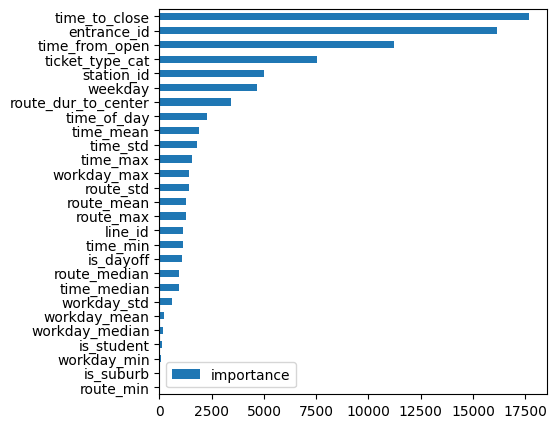

In [83]:
lgbm_feat = pd.DataFrame({'importance': lgbmodel.feature_importance()}, index=X.columns)
lgbm_feat.nlargest(30, columns='importance').sort_values(by='importance').plot(kind='barh', figsize=(5, 5))

## Model

In [42]:
trn_idx, tst_idx = splits[6]
X_train, X_valid, y_train, y_valid = X_train_all.iloc[trn_idx], X_train_all.iloc[tst_idx], y_train_all.time_to_under.iloc[trn_idx], y_train_all.time_to_under.iloc[tst_idx]

In [115]:
lgtrain, lgval = lightgbm.Dataset(X_train, y_train.time_to_under), lightgbm.Dataset(X_valid, y_valid.time_to_under)
lgbmodel = lightgbm.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], callbacks=[lightgbm.log_evaluation(200), lightgbm.early_stopping(50)])
pred_time = lgbmodel.predict(X_test)
r2_score(y_test.time_to_under, pred_time)

0.37893538718229314

# Classifier

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y.label)

In [40]:
params = {'objective': 'multiclassova',
          'n_estimators': 10000,
          'learning_rate': 0.1,
          'num_leaves': 2000,
          'max_depth': 3,
          'bagging_fraction': 0.7,
          'bagging_freq': 1,
          'verbosity': -1}

lgtrain, lgval = lightgbm.Dataset(X_train, y_train.label), lightgbm.Dataset(X_valid, y_valid.label)

model = lightgbm.LGBMClassifier(num_class= 276, **params)
model.fit(
    X_train,
    y_train.label,
    eval_set=[(X_valid, y_valid.label)],
    eval_metric="multiclass",
    callbacks=[lightgbm.early_stopping(15), lightgbm.log_evaluation(50)])  

print(recall_score(y_test.label, model.predict(X_test), average='macro', zero_division=True))

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 15 rounds
[50]	valid_0's multi_logloss: 4.72723
[100]	valid_0's multi_logloss: 4.68244
[150]	valid_0's multi_logloss: 4.65104
[200]	valid_0's multi_logloss: 4.62738
[250]	valid_0's multi_logloss: 4.60941
[300]	valid_0's multi_logloss: 4.59514
[350]	valid_0's multi_logloss: 4.5831
[400]	valid_0's multi_logloss: 4.57399
[450]	valid_0's multi_logloss: 4.56634
[500]	valid_0's multi_logloss: 4.55946
[550]	valid_0's multi_logloss: 4.5545
[600]	valid_0's multi_logloss: 4.54957
[650]	valid_0's multi_logloss: 4.54586
[700]	valid_0's multi_logloss: 4.54293
[750]	valid_0's multi_logloss: 4.54101
[800]	valid_0's multi_logloss: 4.53886
[850]	valid_0's multi_logloss: 4.53765
[900]	valid_0's multi_logloss: 4.53712
Early stopping,

<AxesSubplot: >

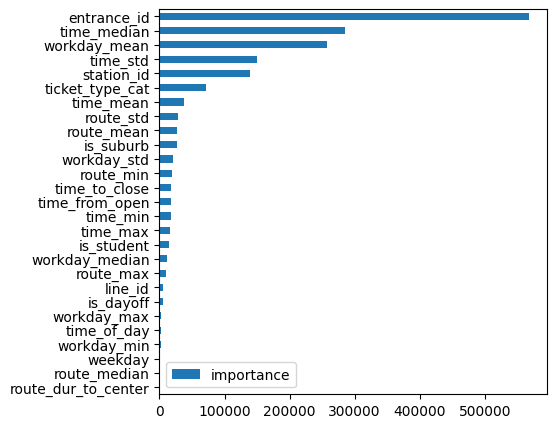

In [84]:
lgbm_feat = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
lgbm_feat.nlargest(30, columns='importance').sort_values(by='importance').plot(kind='barh', figsize=(5, 5))

In [80]:
time_to_under = lgbmodel.predict(df_test_final)
label = model.predict(df_test_final)
pred_df = pd.DataFrame({'id': pd.read_csv('sample_solution.csv').id, 'time_to_under': time_to_under, 'label': label})
pred_df.to_csv('sub_12.csv', index=False)